In [60]:
# Obucavanje se vrsi na sva tri (dva) segmenta, u zavisnosi od nacina snimanja
# Tesiranje alogritma se vrsi koriscenjem train-test-split
# Testirani modeli su: RF, SVM, GNB, LDA

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats

In [62]:
from sklearn.metrics import precision_recall_fscore_support

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [64]:
from sklearn.metrics import classification_report, accuracy_score

In [65]:
import pickle

In [66]:
import numpy as np
from scipy import stats
import pingouin as pg


In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
%matplotlib inline

In [69]:
dat_12_samples = pd.read_csv('/Features.csv',sep=',')
dat_8_samples = pd.read_csv('/Features_without_neutral.csv',sep=',')

In [70]:
temp = dat_12_samples.iloc[0,0]

In [71]:
for i in range(len(dat_12_samples)):
    temp = dat_12_samples.iloc[i,0]
    dat_12_samples.iloc[i,0] = temp[:-4]

In [72]:
for i in range(len(dat_8_samples)):
    temp = dat_8_samples.iloc[i,0]
    dat_8_samples.iloc[i,0] = temp[:-4]

In [73]:
temp1 = dat_12_samples['examinee'].value_counts()
temp2 = dat_8_samples['examinee'].value_counts()

In [74]:
dat = pd.concat([dat_12_samples,dat_8_samples])

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
scaler = StandardScaler()

In [77]:
# with open('subject_ID.pkl', 'rb') as f:
#     le = pickle.load(f)
    
# y = le.transform(dat['examinee'])

In [78]:
X = dat.drop('examinee',axis=1)
y = dat['examinee']

In [120]:
unique_values, counts = np.unique(y, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    if count not in [12,8]:
        print(f"Value {value}: {count} times")

In [80]:
le = LabelEncoder()

y = le.fit_transform(y)

In [81]:
ECG = ['QRS_int','T_int','QT_int','RS_amp','RQ_amp','ECGTcrest','TT1_amp','TT2_amp','RR']

In [82]:
ICG = ['RC_int','RC_int2','BX_int','BX_int2','CB_amp','CX_amp','ICGcrest','CC']

In [83]:
ICG

['RC_int',
 'RC_int2',
 'BX_int',
 'BX_int2',
 'CB_amp',
 'CX_amp',
 'ICGcrest',
 'CC']

In [84]:
values, counts = np.unique(y,return_counts=True)

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
with open('best_params_all.pkl', 'rb') as f:
    best_params_all = pickle.load(f)

In [87]:
print(best_params_all['RF'])

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}


In [88]:
best_params_all.keys()

dict_keys(['RF', 'SVM', 'LDA', 'GNB'])

In [89]:
# train = {'ECG':ECG,'ICG':ICG,'Both':X.columns.to_list()}

In [90]:
both = ECG.copy()
both.extend(ICG)
keys = [ECG,ICG,both]

In [91]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

In [92]:
scaler_dic = {}
scaler_dic[0] = StandardScaler().fit(X[keys[0]])
scaler_dic[1] = StandardScaler().fit(X[keys[1]])
scaler_dic[2] = StandardScaler().fit(X[keys[2]])

In [93]:
num_runs = 20

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rforest_scores = np.zeros((num_runs,3))
rforest_precision_recall_fscore = np.zeros((num_runs,3,4))
for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)
    for num, i_key in enumerate(keys):
        rforest = RandomForestClassifier(n_jobs=-1,**best_params_all['RF'])
        rforest.fit(X_train[i_key],y_train)
        y_hat = rforest.predict(X_test[i_key])
        rforest_scores[i,num] = accuracy_score(y_test, y_hat)
        rforest_precision_recall_fscore[i,num,:] = precision_recall_fscore_support(y_test,y_hat, average='weighted')

In [96]:
temp = precision_recall_fscore_support(y_test,y_hat,average='weighted')

In [97]:
# Classification accuracy for each feature set
feature_set1 = rforest_scores[:, 0]
feature_set2 = rforest_scores[:, 1]
feature_set3 = rforest_scores[:, 2]

# Perform Shapiro-Wilk test for normality
_, p_value1 = stats.shapiro(feature_set1)
_, p_value2 = stats.shapiro(feature_set2)
_, p_value3 = stats.shapiro(feature_set3)

print("Shapiro-Wilk test results:")
print("Feature Set 1 p-value:", p_value1)
print("Feature Set 2 p-value:", p_value2)
print("Feature Set 3 p-value:", p_value3)

# Check normality assumption
if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
    # Non-normal data: use Friedman test
    print("The data does not follow a normal distribution. Performing Friedman test.")
    statistic, p_value = stats.friedmanchisquare(feature_set1, feature_set2, feature_set3)
    
    if p_value < 0.05:
        # Significant result in Friedman test, use Wilcoxon signed-rank test as post-hoc
        wilcox_results = []
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set2))
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set3))
        wilcox_results.append(stats.wilcoxon(feature_set2, feature_set3))
        
        # Apply correction for multiple comparisons (e.g., Bonferroni)
        alpha = 0.05
        adjusted_alpha = alpha / len(wilcox_results)
        
        for i, (set1, set2) in enumerate([(feature_set1, feature_set2), (feature_set1, feature_set3), (feature_set2, feature_set3)]):
            _, adjusted_p = wilcox_results[i]
            if adjusted_p < adjusted_alpha:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is significant (adjusted p-value: {adjusted_p})")
            else:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is not significant (adjusted p-value: {adjusted_p})")
    
else:
    # Normally distributed data: use repeated measures ANOVA
    print("The data follows a normal distribution. Performing repeated measures ANOVA.")
    
    df = pd.DataFrame({
        'scores': np.concatenate([feature_set1, feature_set2, feature_set3]),
        'features': np.array(['Feature Set 1'] * len(feature_set1) + ['Feature Set 2'] * len(feature_set2) + ['Feature Set 3'] * len(feature_set3)),
        'subjects': np.concatenate([np.arange(len(feature_set1)) for _ in range(3)])
    })
    
    aov = pg.rm_anova(dv='scores', within='features', subject='subjects', data=df)
    p_value = aov.at[0, 'p-unc']
    
    print("ANOVA results:\n", aov)
    
    if p_value < 0.05:
        # Significant result in ANOVA, use paired t-tests with Bonferroni correction
        pairs = [('Feature Set 1', 'Feature Set 2'), ('Feature Set 1', 'Feature Set 3'), ('Feature Set 2', 'Feature Set 3')]
        for p1, p2 in pairs:
            _, p_val = stats.ttest_rel(df[df['features'] == p1]['scores'], df[df['features'] == p2]['scores'])
            
            # Applying Bonferroni correction
            corrected_p = p_val * 3
            print(f"Paired t-test between {p1} and {p2}: p-value = {corrected_p}")


Shapiro-Wilk test results:
Feature Set 1 p-value: 0.8965145945549011
Feature Set 2 p-value: 0.19625937938690186
Feature Set 3 p-value: 0.13787363469600677
The data follows a normal distribution. Performing repeated measures ANOVA.
ANOVA results:
      Source  ddof1  ddof2             F         p-unc       ng2       eps
0  features      2     38  10566.428553  6.712093e-53  0.995663  0.696361
Paired t-test between Feature Set 1 and Feature Set 2: p-value = 3.161788517117298e-26
Paired t-test between Feature Set 1 and Feature Set 3: p-value = 8.603009669619133e-13
Paired t-test between Feature Set 2 and Feature Set 3: p-value = 5.1158943086831685e-30


In [98]:
rforest_mean = np.mean(rforest_scores, axis = 0)*100
rforest_std = np.std(rforest_scores, axis = 0)*100

In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [100]:
X_train[i_key]

,QRS_int,T_int,QT_int,RS_amp,RQ_amp,ECGTcrest,TT1_amp,TT2_amp,RR,RC_int,RC_int2,BX_int,BX_int2,CB_amp,CX_amp,ICGcrest,CC
971,67.0,209.91,381.70,1.19,0.98,1.78,0.36,0.36,916.9,69.95,73.05,270.5,282.49,0.85,1.09,2.08,916.0
228,59.5,259.98,446.60,1.08,0.83,1.51,0.06,0.05,603.7,65.80,84.69,353.0,454.32,1.06,1.94,1.63,604.4
823,66.0,218.25,430.73,1.00,1.04,1.69,0.13,0.10,749.9,62.35,72.00,280.5,323.92,1.71,1.91,1.99,748.8
1292,87.0,246.58,491.89,0.89,0.84,1.81,0.16,0.16,619.0,75.90,96.47,264.0,335.55,1.50,1.68,1.87,619.0
1714,57.0,240.77,416.61,1.12,1.11,1.70,0.30,0.30,854.0,134.30,145.33,247.5,267.82,1.16,2.48,1.62,847.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,66.5,198.61,384.73,0.76,0.57,1.67,0.12,0.14,776.4,84.40,95.79,257.5,292.24,1.01,1.65,1.73,777.8
263,57.5,209.81,407.61,1.14,0.86,1.65,0.12,0.16,626.0,68.80,86.96,307.0,388.02,0.88,1.60,1.59,625.9
270,76.0,240.29,461.91,1.77,1.42,1.62,0.32,0.30,645.1,77.65,96.68,397.0,494.28,1.34,1.57,1.83,644.8
541,86.5,217.56,419.24,0.89,0.72,1.73,0.20,0.22,723.1,68.25,80.26,273.0,321.04,1.13,1.85,1.96,723.8


In [101]:
lda_scores = np.zeros((num_runs,3))
lda_precision_recall_fscore = np.zeros((num_runs,3,4))
for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)
    for num, i_key in enumerate(keys):
        lda = LinearDiscriminantAnalysis(**best_params_all['LDA'])
        lda.fit(scaler_dic[num].transform(X_train[i_key]),y_train)
        y_hat = lda.predict(scaler_dic[num].transform(X_test[i_key]))
        lda_scores[i,num] = (accuracy_score(y_test, y_hat))
        lda_precision_recall_fscore[i,num,:] = precision_recall_fscore_support(y_test,y_hat,average='weighted')

In [102]:
import numpy as np
from scipy import stats
import pingouin as pg

# Classification accuracy for each feature set
feature_set1 = lda_scores[:, 0]
feature_set2 = lda_scores[:, 1]
feature_set3 = lda_scores[:, 2]

# Perform Shapiro-Wilk test for normality
_, p_value1 = stats.shapiro(feature_set1)
_, p_value2 = stats.shapiro(feature_set2)
_, p_value3 = stats.shapiro(feature_set3)

print("Shapiro-Wilk test results:")
print("Feature Set 1 p-value:", p_value1)
print("Feature Set 2 p-value:", p_value2)
print("Feature Set 3 p-value:", p_value3)

# Check normality assumption
if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
    # Non-normal data: use Friedman test
    print("The data does not follow a normal distribution. Performing Friedman test.")
    statistic, p_value = stats.friedmanchisquare(feature_set1, feature_set2, feature_set3)
    
    if p_value < 0.05:
        # Significant result in Friedman test, use Wilcoxon signed-rank test as post-hoc
        wilcox_results = []
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set2))
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set3))
        wilcox_results.append(stats.wilcoxon(feature_set2, feature_set3))
        
        # Apply correction for multiple comparisons (e.g., Bonferroni)
        alpha = 0.05
        adjusted_alpha = alpha / len(wilcox_results)
        
        for i, (set1, set2) in enumerate([(feature_set1, feature_set2), (feature_set1, feature_set3), (feature_set2, feature_set3)]):
            _, adjusted_p = wilcox_results[i]
            if adjusted_p < adjusted_alpha:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is significant (adjusted p-value: {adjusted_p})")
            else:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is not significant (adjusted p-value: {adjusted_p})")

    
else:
    # Normally distributed data: use repeated measures ANOVA
    print("The data follows a normal distribution. Performing repeated measures ANOVA.")
    
    df = pd.DataFrame({
        'scores': np.concatenate([feature_set1, feature_set2, feature_set3]),
        'features': np.array(['Feature Set 1'] * len(feature_set1) + ['Feature Set 2'] * len(feature_set2) + ['Feature Set 3'] * len(feature_set3)),
        'subjects': np.concatenate([np.arange(len(feature_set1)) for _ in range(3)])
    })
    
    aov = pg.rm_anova(dv='scores', within='features', subject='subjects', data=df)
    p_value = aov.at[0, 'p-unc']
    
    print("ANOVA results:\n", aov)
    
    if p_value < 0.05:
        # Significant result in ANOVA, use paired t-tests with Bonferroni correction
        pairs = [('Feature Set 1', 'Feature Set 2'), ('Feature Set 1', 'Feature Set 3'), ('Feature Set 2', 'Feature Set 3')]
        for p1, p2 in pairs:
            _, p_val = stats.ttest_rel(df[df['features'] == p1]['scores'], df[df['features'] == p2]['scores'])
            
            # Applying Bonferroni correction
            corrected_p = p_val * 3
            print(f"Paired t-test between {p1} and {p2}: p-value = {corrected_p}")


Shapiro-Wilk test results:
Feature Set 1 p-value: 0.799420177936554
Feature Set 2 p-value: 0.07385740429162979
Feature Set 3 p-value: 0.010053030215203762
The data does not follow a normal distribution. Performing Friedman test.
Wilcoxon test between Feature Set 1 and Feature Set 2 is significant (adjusted p-value: 1.9073486328125e-06)
Wilcoxon test between Feature Set 2 and Feature Set 3 is significant (adjusted p-value: 1.9073486328125e-06)
Wilcoxon test between Feature Set 3 and Feature Set 4 is significant (adjusted p-value: 1.9073486328125e-06)


In [103]:
lda_mean = np.mean(lda_scores,axis=0)*100
lda_std = np.std(lda_scores,axis=0)*100

In [104]:
from sklearn.naive_bayes import GaussianNB

In [105]:
print(best_params_all['GNB'])

{'var_smoothing': 0.01519911082952933}


In [106]:
gnb_scores = np.zeros((num_runs,3))
gnb_precision_recall_fscore = np.zeros((num_runs,3,4))
for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)
    for num, i_key in enumerate(keys):
        gnb = GaussianNB(**best_params_all['GNB'])
        gnb.fit(scaler_dic[num].transform(X_train[i_key]),y_train)
        y_hat = gnb.predict(scaler_dic[num].transform(X_test[i_key]))
        gnb_scores[i,num] = (accuracy_score(y_test, y_hat))
        gnb_precision_recall_fscore[i,num,:] = precision_recall_fscore_support(y_test,y_hat,average='weighted')

In [107]:
import numpy as np
from scipy import stats
import pingouin as pg

# Classification accuracy for each feature set
feature_set1 = gnb_scores[:, 0]
feature_set2 = gnb_scores[:, 1]
feature_set3 = gnb_scores[:, 2]

# Perform Shapiro-Wilk test for normality
_, p_value1 = stats.shapiro(feature_set1)
_, p_value2 = stats.shapiro(feature_set2)
_, p_value3 = stats.shapiro(feature_set3)

print("Shapiro-Wilk test results:")
print("Feature Set 1 p-value:", p_value1)
print("Feature Set 2 p-value:", p_value2)
print("Feature Set 3 p-value:", p_value3)

# Check normality assumption
if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
    # Non-normal data: use Friedman test
    print("The data does not follow a normal distribution. Performing Friedman test.")
    statistic, p_value = stats.friedmanchisquare(feature_set1, feature_set2, feature_set3)
    print(f"Friedman test statistics: {statistic}, p-value: {p_value}")
    if p_value < 0.05:
        # Significant result in Friedman test, use Wilcoxon signed-rank test as post-hoc
        wilcox_results = []
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set2))
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set3))
        wilcox_results.append(stats.wilcoxon(feature_set2, feature_set3))
        
        # Apply correction for multiple comparisons (e.g., Bonferroni)
        alpha = 0.05
        adjusted_alpha = alpha / len(wilcox_results)
        
        for i, (set1, set2) in enumerate([(feature_set1, feature_set2), (feature_set1, feature_set3), (feature_set2, feature_set3)]):
            _, adjusted_p = wilcox_results[i]
            if adjusted_p < adjusted_alpha:
                print(f"Wilcoxon test is significant (statistics: {wilcox_results[0]}, adjusted p-value: {adjusted_p})")
            else:
                print(f"Wilcoxon test is not significant (statistics: {wilcox_results[0]}, adjusted p-value: {adjusted_p})")

    
else:
    # Normally distributed data: use repeated measures ANOVA
    print("The data follows a normal distribution. Performing repeated measures ANOVA.")
    
    df = pd.DataFrame({
        'scores': np.concatenate([feature_set1, feature_set2, feature_set3]),
        'features': np.array(['Feature Set 1'] * len(feature_set1) + ['Feature Set 2'] * len(feature_set2) + ['Feature Set 3'] * len(feature_set3)),
        'subjects': np.concatenate([np.arange(len(feature_set1)) for _ in range(3)])
    })
    
    aov = pg.rm_anova(dv='scores', within='features', subject='subjects', data=df)
    p_value = aov.at[0, 'p-unc']
    
    print("ANOVA results:\n", aov)
    
    if p_value < 0.05:
        # Significant result in ANOVA, use paired t-tests with Bonferroni correction
        pairs = [('Feature Set 1', 'Feature Set 2'), ('Feature Set 1', 'Feature Set 3'), ('Feature Set 2', 'Feature Set 3')]
        for p1, p2 in pairs:
            _, p_val = stats.ttest_rel(df[df['features'] == p1]['scores'], df[df['features'] == p2]['scores'])
            
            # Applying Bonferroni correction
            corrected_p = p_val * 3
            print(f"Paired t-test between {p1} and {p2}: p-value = {corrected_p}")


Shapiro-Wilk test results:
Feature Set 1 p-value: 0.6058889627456665
Feature Set 2 p-value: 0.9886970520019531
Feature Set 3 p-value: 0.49781668186187744
The data follows a normal distribution. Performing repeated measures ANOVA.
ANOVA results:
      Source  ddof1  ddof2            F         p-unc       ng2       eps
0  features      2     38  5729.904962  7.314775e-48  0.994017  0.860398
Paired t-test between Feature Set 1 and Feature Set 2: p-value = 3.613465299353466e-24
Paired t-test between Feature Set 1 and Feature Set 3: p-value = 1.5475309398659393e-11
Paired t-test between Feature Set 2 and Feature Set 3: p-value = 2.1639338663896794e-28


In [108]:
# print(wilcox_results[0])
# print(wilcox_results[1])
# print(wilcox_results[2])

In [109]:
gnb_mean = np.mean(gnb_scores, axis = 0)*100
gnb_std = np.std(gnb_scores, axis = 0)*100

In [110]:
from sklearn.svm import SVC

In [111]:
svm_scores = np.zeros((num_runs,3))
svm_precision_recall_fscore = np.zeros((num_runs,3,4))
for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)
    for num, i_key in enumerate(keys):
        svm = SVC(**best_params_all['SVM'])
        svm.fit(scaler_dic[num].transform(X_train[i_key]),y_train)
        y_hat = svm.predict(scaler_dic[num].transform(X_test[i_key]))
        svm_scores[i,num] = accuracy_score(y_test, y_hat)
        svm_precision_recall_fscore[i,num,:] = precision_recall_fscore_support(y_test,y_hat,average='weighted')

In [112]:
import numpy as np
from scipy import stats
import pingouin as pg

# Classification accuracy for each feature set
feature_set1 = svm_scores[:, 0]
feature_set2 = svm_scores[:, 1]
feature_set3 = svm_scores[:, 2]

# Perform Shapiro-Wilk test for normality
_, p_value1 = stats.shapiro(feature_set1)
_, p_value2 = stats.shapiro(feature_set2)
_, p_value3 = stats.shapiro(feature_set3)

print("Shapiro-Wilk test results:")
print("Feature Set 1 p-value:", p_value1)
print("Feature Set 2 p-value:", p_value2)
print("Feature Set 3 p-value:", p_value3)

# Check normality assumption
if any(p_value < 0.05 for p_value in [p_value1, p_value2, p_value3]):
    # Non-normal data: use Friedman test
    print("The data does not follow a normal distribution. Performing Friedman test.")
    statistic, p_value = stats.friedmanchisquare(feature_set1, feature_set2, feature_set3)
    
    if p_value < 0.05:
        # Significant result in Friedman test, use Wilcoxon signed-rank test as post-hoc
        wilcox_results = []
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set2))
        wilcox_results.append(stats.wilcoxon(feature_set1, feature_set3))
        wilcox_results.append(stats.wilcoxon(feature_set2, feature_set3))
        
        # Apply correction for multiple comparisons (e.g., Bonferroni)
        alpha = 0.05
        adjusted_alpha = alpha / len(wilcox_results)
        
        for i, (set1, set2) in enumerate([(feature_set1, feature_set2), (feature_set1, feature_set3), (feature_set2, feature_set3)]):
            _, adjusted_p = wilcox_results[i]
            if adjusted_p < adjusted_alpha:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is significant (adjusted p-value: {adjusted_p})")
            else:
                print(f"Wilcoxon test between Feature Set {i + 1} and Feature Set {i + 2} is not significant (adjusted p-value: {adjusted_p})")

    
else:
    # Normally distributed data: use repeated measures ANOVA
    print("The data follows a normal distribution. Performing repeated measures ANOVA.")
    
    df = pd.DataFrame({
        'scores': np.concatenate([feature_set1, feature_set2, feature_set3]),
        'features': np.array(['Feature Set 1'] * len(feature_set1) + ['Feature Set 2'] * len(feature_set2) + ['Feature Set 3'] * len(feature_set3)),
        'subjects': np.concatenate([np.arange(len(feature_set1)) for _ in range(3)])
    })
    
    aov = pg.rm_anova(dv='scores', within='features', subject='subjects', data=df)
    p_value = aov.at[0, 'p-unc']
    
    print("ANOVA results:\n", aov)
    
    if p_value < 0.05:
        # Significant result in ANOVA, use paired t-tests with Bonferroni correction
        pairs = [('Feature Set 1', 'Feature Set 2'), ('Feature Set 1', 'Feature Set 3'), ('Feature Set 2', 'Feature Set 3')]
        for p1, p2 in pairs:
            _, p_val = stats.ttest_rel(df[df['features'] == p1]['scores'], df[df['features'] == p2]['scores'])
            
            # Applying Bonferroni correction
            corrected_p = p_val * 3
            print(f"Paired t-test between {p1} and {p2}: p-value = {corrected_p}")


Shapiro-Wilk test results:
Feature Set 1 p-value: 0.3657345175743103
Feature Set 2 p-value: 0.3087085783481598
Feature Set 3 p-value: 0.2661595344543457
The data follows a normal distribution. Performing repeated measures ANOVA.
ANOVA results:
      Source  ddof1  ddof2            F         p-unc       ng2       eps
0  features      2     38  3995.133004  6.730929e-45  0.989591  0.997196
Paired t-test between Feature Set 1 and Feature Set 2: p-value = 2.6706937437331006e-24
Paired t-test between Feature Set 1 and Feature Set 3: p-value = 0.0006623305006978226
Paired t-test between Feature Set 2 and Feature Set 3: p-value = 5.46300873096237e-25


In [113]:
svm_mean = np.mean(svm_scores, axis = 0)*100
svm_std = np.std(svm_scores, axis = 0)*100

In [114]:
labels = ['RF', 'SVM', 'GNB', 'LDA']

In [115]:
# x_pos = np.arange(len(labels))
# fig, ax = plt.subplots(figsize=(12, 10))
# ax.bar(x_pos, alg_means,
#        yerr=alg_stds,
#        align='center',
#        capsize=30,
#        color= '#660000')
# ax.set_ylabel('Accuracy of classification [%]', fontsize = 18)
# ax.yaxis.grid(True, linestyle='--', color = 'black')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels, fontsize = 16)
# ax.set_title('Comparative analysis of model accuracy for biometic identification', fontsize = 18)
# ax.yaxis.grid(True)

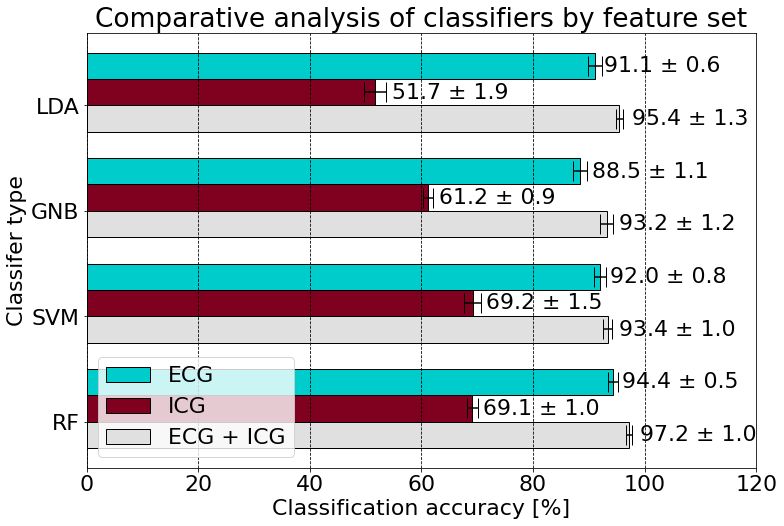

In [116]:
ecg_mean = [rforest_mean[0], svm_mean[0], gnb_mean[0], lda_mean[0]]
icg_mean = [rforest_mean[1], svm_mean[1], gnb_mean[1], lda_mean[1]]
all_mean = [rforest_mean[2], svm_mean[2], gnb_mean[2], lda_mean[2]]

ecg_std = [rforest_std[0], svm_std[0], gnb_std[0], lda_std[0]]
icg_std = [rforest_std[1], svm_std[1], gnb_std[1], lda_std[1]]
all_std = [rforest_std[2], svm_std[2], gnb_std[2], lda_std[2]]

plt.rcParams.update({'font.size': 22})

n = 4
r = np.arange(n)
height = 0.25

plt.figure(figsize=(12, 8))
plt.barh(r+ 2 * height, ecg_mean, color='#00CCCC',
         xerr=ecg_std, capsize=10,
         height=height, edgecolor='black',
         label='ECG')
plt.barh(r + height, icg_mean, color='#800020',
         xerr=icg_std, capsize=10,
         height=height, edgecolor='black',
         label='ICG')
plt.barh(r , all_mean, color='#E0E0E0',
         xerr=all_std, capsize=10,
         height=height, edgecolor='black',
         label='ECG + ICG')

plt.grid(axis='x', linestyle='--', color='black')
plt.yticks(r + height/2, labels)
plt.legend(loc='lower left')
plt.xlabel('Classification accuracy [%]')
plt.ylabel('Classifer type')
plt.title('Comparative analysis of classifiers by feature set')
plt.xlim((0,120))

for i, v in enumerate(all_mean):
    plt.text(v + ecg_std[i] + 1, i, f'{v:.1f} ± {ecg_std[i]:.1f}', color='black', va='center')

for i, v in enumerate(icg_mean):
    plt.text(v + icg_std[i] + 1, i + height, f'{v:.1f} ± {icg_std[i]:.1f}', color='black', va='center')

for i, v in enumerate(ecg_mean):
    plt.text(v + all_std[i] + 1, i + 2 * height, f'{v:.1f} ± {all_std[i]:.1f}', color='black', va='center')

In [117]:
print(np.round(np.mean(gnb_precision_recall_fscore,axis=0)*100,2).T)
print('='*30)
print(np.round(np.std(gnb_precision_recall_fscore,axis=0)*100,2).T)

[[90.38 61.45 95.27]
 [88.46 61.2  93.21]
 [87.88 58.14 93.05]
 [  nan   nan   nan]]
[[1.22 1.83 0.74]
 [1.24 0.9  1.11]
 [1.24 1.17 1.09]
 [ nan  nan  nan]]


In [119]:
mean_values = np.round(np.mean(rforest_precision_recall_fscore, axis=0)*100, 2).T
std_values = np.round(np.std(rforest_precision_recall_fscore, axis=0)*100, 2).T
for row_mean, row_std in zip(mean_values, std_values):
    formatted_row = [f"{m} ± {s}" for m, s in zip(row_mean, row_std)]
    print(' | '.join(formatted_row))

95.55 ± 0.77 | 70.53 ± 1.67 | 97.84 ± 0.43
94.37 ± 0.95 | 69.13 ± 0.95 | 97.16 ± 0.51
94.08 ± 1.0 | 66.95 ± 1.2 | 97.03 ± 0.53
nan ± nan | nan ± nan | nan ± nan
